In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



%matplotlib inline

df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# Feature engineering
- null data부터 처리
- feature를 보고 참고하여 채워야 한다.
- 어떻게 채우냐에 따라 모델의 성능이 결정된다.
- 실제 모델 학습에 쓸 것이니 train뿐 아니라 test에도 해주어야 한다.

## fill null in Age
- 이름 앞에 붙는 title을 활용해보자 => 정규식 => 이런 아이디어 ....
- pandas series의 str(스트링으로 바꿔줌) > extract(정규표현식 적용 가능하게)


In [2]:
print(df_train.Name)

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object


In [3]:
# . 뒤로 있는 1 단어를 찾아라
print( df_train.Name.str.extract('([A-Za-z]+)\.') )

        0
0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
..    ...
886   Rev
887  Miss
888  Miss
889    Mr
890    Mr

[891 rows x 1 columns]


In [4]:
# . 앞에 있는 1 단어를 찾아라
print( df_train.Name.str.extract('([A-Za-z]+)\,') )

             0
0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
4        Allen
..         ...
886   Montvila
887     Graham
888   Johnston
889       Behr
890     Dooley

[891 rows x 1 columns]


In [5]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [6]:
# crosstab => 이니셜과 성별간의 카운트
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [7]:
# 여자 => Miss / 남자 => Mr / 기타 => Other
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [8]:
df_train.groupby('Initial').mean()

# 여성 관련 Miss, Mrs가 생존율이 높다

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


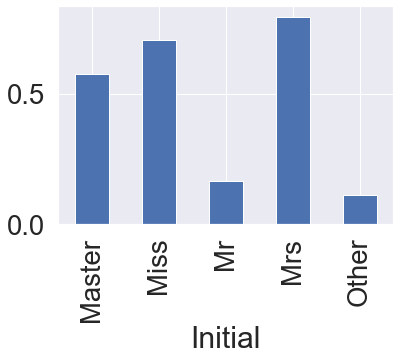

In [9]:
# barplot (바플롯)
df_train.groupby('Initial')['Survived'].mean().plot.bar()

# 바 그래프로

### Null 값을 어떻게 채우는 방법
1. statistics => 통계 활용
1. 새로운 머신러닝 알고리즘 활용
1. etc ...

- statistics는 train 데이터로 얻어야 한다.
- train 기반으로 얻은 것으로 test의 null값을 채우는 것!

In [10]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


#### 여기서는 Age의 평균으로 null값을 채운다

In [11]:
df_train.loc[ ( df_train.Age.isnull() ) & ( df_train.Initial=="Mr" ), "Age" ] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### fill null in Embarked

In [12]:
print("Embarked has ", sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


- Embarked에는 S가 가장 많았고 null값이 2개밖에 없기에 S로 채운다.

In [13]:
# inplace=True  >>또 다른 객체를 반환하지 않고 기존 객체를 수정
df_train['Embarked'].fillna('S', inplace=True)

In [14]:
df_test['Embarked'].fillna('S', inplace=True)

## Change Age(continuous to categorical)

- Age를 몇개 그룹으로 나누어 카테고리화할 수 있다.
- 현재의 경우, information loss 우려 존재

- dataframe의 인덱싱 방법 => loc  
  10살 단위로 구분

In [15]:
df_train['Age_cat'] = 0
# Age가 10보다 작으면 / Age_cat은 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
# Age가 10보다 크고, 20보다 작으면 / Age_cat은 1 ....
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- apply 메소드로 넣기
  10살 단위로 구분

In [16]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [17]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [18]:
# 이제 확인했으니 안쓰는 열들 삭제

df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### 카테고리형 데이터 처리하기 => Initial, Embarkedm, Sex
- 이런 형태의 데이터를 모델에 인풋할 때  
  컴퓨터가 인식할 수 있게 수치화해주어야 한다.
 

#### 먼저 칼럼에 어떤 값들이 있는지 확인 
- unique()
- value_counts()

In [19]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [20]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- map method를 활용한다.

In [21]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [22]:
# null 확인
df_train['Embarked'].isnull().any()

False

In [23]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [24]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

### 상관관계 탐색
- feature 간의 상관관계

- 변수 간의 Pearson correlation( 피어슨 계수? ) ( -1, 1 )사이의 값을 얻을 수 있다
- -1 -> 음의 상관관계 / +1 -> 양의 상관관계 / 0 -> 상관관계 없음  
-1.0  ~ -0.7 => 매우 강한 음의 상관관계  
-0.7 ~ -0.3 => 강한 음의 상관관계  
-0.3 ~ -0.1 => 음의 상관관계  
-0.1 ~ 0.1   => 상관관계 없음  
0.1 ~ 0.3 => 양의 상관관계  
0.3 ~ 0.7 => 강한 양의 상관관계  
0.7 ~ 1.0 => 매우 강한 양의 상관관계  
- 이를 위해서 matrix형태가 좋다 => heatmap plot


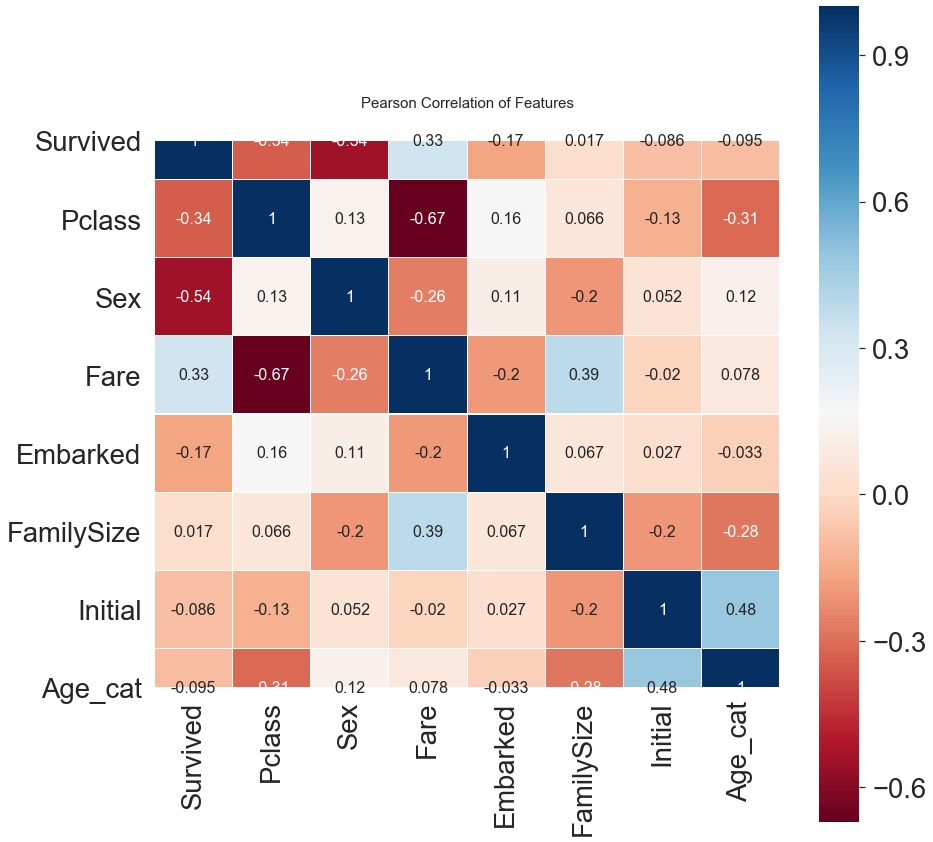

In [25]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 15))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- Fare <> Pclass => -0.67  
  음의 상관관계 => Pclass가 낮을수록 등급이 높다 => Fare가 크다, 비싸다.
- Sex <> Survived => -0.54  
  음의 상관관계 => 성별이 0(여성)일수록 생존율이 높다.
- Pclass <> Survived => -0.34  
  음의 상관관계  => Pclass가 낮을수록 ( 등급이 높을수록 ) => 생존율이 높다.

- EDA에서 했듯이 Sex Pclass가 Survived와 상관관계가 있다.
- 생각보다 fare와 Embarked도 상관관계가 있음을 볼 수 있다.
- 서로 강한 상관관계를 가지는 feature가 없다.  
  => 모델 학습시 불필요한(redundant) feature가 없다는 것을 의미  
  => 1 ~ -1 사이의 상관관계를 가진 feature가 있으면, 우리가 얻을 수 있는 정보는 사실 하나인 것이다..

# 전처리!

## One-hot encoding on Initial and Embarked

- 수치화한 카테고리 데이터를 그대로 넣어도 되지만..  
  모델의 성능을 위해서 one-hot encoding을 해줄 수 있다.
- 수치화는 단순히  "" == 0, "" == 1 ...
- one-hot encoding   
  (0, 1)로 이루어진 5차원 벡터로 나타내는 것

- 위와 같은 작업을 직접 코딩할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있다.
- 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생긴다.
- Initial 을 prefix로 두어서 구분이 쉽게 만든다.

In [26]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [27]:
df_train.head()

# initial => 0~4로 각각이 카테고리화

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [28]:
# Embarked도 똑같이 진행해준다.
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')


#### 대신 이렇게 하면 카테고리가 지나치게 많아질 수 있다. => 학습이 버거워 질 우려
#### 다른 기법이 있다!

## Drop columns
- 필요없는 칼럼 삭제

In [29]:
try:
    df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
    df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
except:
    pass
# 필요없는 열 삭제

In [30]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


# Building machine learning model and prediction using the trained model

## sklearn
- featue engineering,   
  preprocessing,  
  지도 학습 알고리즘,   
  비지도 학습 알고리즘,   
  모델 평가,   
  파이프라인  
- 머신러닝의 작업들이 대부분 들어있다.
- 데이터분석 + 머신러닝 => 기본적인 라이브러리

In [31]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

- target class(survived) => 0 or 1  
  => binary classification

- train set의 survived를 제외한 input으로 모델을 최적화하여 각 샘플의 생존유무를 판단하는 모델 생성
- 학습하지 않는 test set으로 샘플의 생존유무를 판단

In [32]:
# 학습에 쓸 데이터 X_train
# 목표 target_label
# 테스트용 데이터 X_test

X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 실제로는 valid set을 따로 만들어 모델 평가를 한다.  
  => 좋은 모델을 만들기 위해 (테스트 X)

In [33]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

### sklearn documentation
- https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- 추가로 알아봐라!

- 여기서는 랜덤포레스트 방식 사용한다.
### 랜덤포레스트
- 결정트리 기반 모델, 여러 결정 트리들을 앙상블한 모델
- n_estimators,   
  max_features,   
  max_depth,    
  min_samples_split,   
  min_samples_leaf   
  등등  파라미터 존재
- 세팅에 따라 모델의 성능이 달라진다.
- 여기서는 기본 default 세팅으로 진행

- 모델 객체 생성 => fit 메소드로 학습
- valid set input을 넣어주고 예측값 ( X_vld -> sample의 생존 여부 )  획득

## Model generation and prediction

In [34]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [35]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.46% 정확도로 생존을 맞춤


- 끝이다..
- 파라미터 튜닝을 통해 업그레이드를 해볼 수 있다...

## Feature importance
- 어떤 feature 에 영향을 많이 받았는 지 확인
- 학습된 모델은 기본적으로 featureimportances를 가지고 있어 수치를 쉽게 얻을 수 있다.  
  => pandas series를 통해 sorting하여 그래프 작성 가능

In [71]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

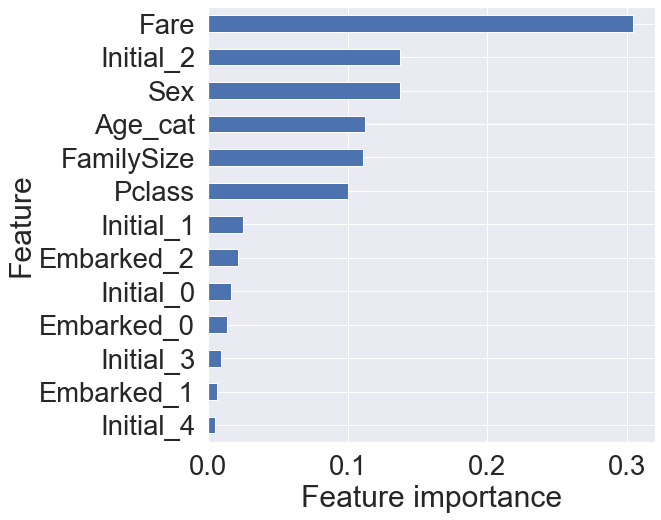

In [64]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# 중요도가 높은 순
# Fare > Initial_2 > Sex ...

- 이 값을 통해 Fare가 중요한 feature임을 판단할 수 있지만  
  => 모델에 귀속된 결과이므로, 통계적으로 더 살펴보아야 한다.

- feature importce를 가지고 feature selection / feature 제거 등 추가 작업을 할 수 있다. 

## Prediction on Test set
- 제출해보자?

In [67]:
submission = pd.read_csv('input/gender_submission.csv')

In [68]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [69]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [70]:
submission.to_csv('./my_first_submission.csv', index=False)